In [2]:
import os, random

from keras import backend as K
#os.environ["KERAS_BACKEND"] = "tensorflow"

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
import h5py
import numpy as np
from keras.utils import plot_model

from keras.layers import Input, merge, Lambda
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D, AveragePooling2D, \
    Conv2DTranspose
from keras.layers.normalization import *
from keras.optimizers import *
from keras import initializers
import matplotlib.pyplot as plt
import pickle, random, sys, keras
from keras.models import Model
from tqdm import tqdm
import time
import os, sys
from functools import partial

import random

In [3]:
##### load and preprocess the dataset ##
batch_size = 1024
num_ep = 7 # number of facial expressions (referenced in y_train2)
num_pp = 6 # number of identities (referenced in y_train1)
epochs = 5000
img_rows, img_cols = 64, 64
c_dim = num_pp
date = 2020

# Extracting data from processed h5py file
print ('Loading data...')
f = h5py.File('/content/drive/My Drive/pprl_vgan/processed_dataset.h5')
print ('Finished loading...')

dataset_size = 2176
training_size = 2048
test_size = 128

# Extracting information from htf5 files
x_train = f['x_train'][()][:]
x_test  = f['x_test'][()][:]
x_train = x_train[:training_size]
x_test  = x_test[training_size:training_size+test_size]

y_train1 = f['y_train1'][()][:]
y_test1  = f['y_test1'][()][:]
y_train2 = f['y_train2'][()][:]
y_test2  = f['y_test2'][()][:]
y_train1 = y_train1[:training_size]
y_test1  = y_test1[training_size:training_size+test_size]
y_train2 = y_train2[:training_size]
y_test2  = y_test2[training_size:test_size]

# Change data into correct form
y_train1 = keras.utils.to_categorical(y_train1, num_pp)
y_test1  = keras.utils.to_categorical(y_test1, num_pp)
y_train2 = keras.utils.to_categorical(y_train2, num_ep)
y_test2  = keras.utils.to_categorical(y_test2, num_ep)

x_ori = np.divide(x_train, 255)

Loading data...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if sys.path[0] == '':


Finished loading...


In [4]:
def generate_dataset(ee):
    ## save to numpyz###############
    c = np.random.randint(num_pp, size=x_train.shape[0])
    c_train = keras.utils.to_categorical(c, num_pp)
    c = np.random.randint(num_pp, size=x_test.shape[0])
    c_test = keras.utils.to_categorical(c, num_pp)

    [z_train, mean_var_train] = encoder.predict(x_train)
    encoded_xtrain = decoder.predict([z_train, c_train])

    [z_test, mean_var_test] = encoder.predict(x_test)
    encoded_xtest = decoder.predict([z_test, c_test])

    np.savez('/Z_' + str(date) + 'epoch'+str(ee)+'_64_64_VAE_GAN_labelfull_v2.npz',
             encoded_xtrain, y_train1, y_train2, c_train, encoded_xtest, y_test1, y_test2, c_test)
    np.savez('/X_' + str(date) + 'epoch'+str(ee)+ '_fi_512_VAE_GAN_labelfull_v2.npz',
             z_train, y_train1, y_train2, c_train, z_test, y_test1, y_test2, c_test)

opt  = RMSprop(lr=0.0002, decay=1e-6)
dopt = RMSprop(lr=0.0002, decay=1e-6)

# Define KL loss function for network training
def KL_loss(y_true, y_pred):
    z_mean = y_pred[:, 0:z_dim]
    z_log_var = y_pred[:, z_dim:2 * z_dim]
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(kl_loss)

# Returns sample from probability distribution (uses Keras backend)
epsilon_std = 1
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], z_dim), mean=0.,
                              stddev=epsilon_std)
    return (z_mean + K.exp(K.square(z_log_sigma) / 2) * epsilon)

In [5]:
### Defining Encoder and Decoder

# This method takes in the input z_dim (shape of latent space), input shape, units and dropout
# Then, it returns a keras.Model which takes in an 'Input' image x with shape=input_shape
# and which outputs the encoded shape z, and the probability distribution h2
def model_encoder(z_dim, input_shape, units=512, dropout=0.3):
    k = 8
    x = Input(input_shape)
    h = Conv2D(int(units/8), (k, k), strides=(2, 2), padding='same')(x)
    h = BatchNormalization(momentum=0.8)(h)
    h = Dropout(dropout)(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(int(units/4), (k, k), strides=(2, 2), padding='same')(h)
    h = BatchNormalization(momentum=0.8)(h)
    h = Dropout(dropout)(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(int(units/2), (k, k), strides=(2, 2), padding='same')(h)
    h = BatchNormalization(momentum=0.8)(h)
    h = Dropout(dropout)(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(units, (k, k), strides=(2, 2), padding='same')(h)
    h = BatchNormalization(momentum=0.8)(h)
    h = Dropout(dropout)(h)
    h = LeakyReLU(0.2)(h)
    h = Flatten()(h)
    mean = Dense(z_dim, name="encoder_mean")(h)
    logvar = Dense(z_dim, name="encoder_sigma", activation='sigmoid')(h)

    z = Lambda(function=sampling, output_shape=(z_dim,))([mean, logvar])
    h2 = keras.layers.concatenate([mean, logvar])
    return [Model(x, [z, h2], name='Encoder'), mean, logvar]


# This function takes z_dim and c_dim as inputs, where z_dim is the shape of the latent space, and c_dim is
# the number of people (6 in this case), in binary form. It returns a keras.Model which takes the encoded
# image 'x', and identity information 'auxiliary_c' as input, and returns a decoded image h
def model_decoder(z_dim, c_dim):
    k = 8
    x = Input(shape=(z_dim,))
    auxiliary_c = Input(shape=(c_dim,), name='aux_input_c')
    h = keras.layers.concatenate([x, auxiliary_c])
    h = Dense(4 * 4 * 128, activation='relu')(h)
    h = Reshape((4, 4, 128))(h)
    h = Conv2DTranspose(units, (k, k), strides=(2, 2), padding='same', activation='relu')(h)  # 32*32*64
    h = BatchNormalization(momentum=0.8)(h)
    h = Conv2DTranspose(int(units/2), (k, k), strides=(2, 2), padding='same', activation='relu')(h)  # 64*64*64
    h = BatchNormalization(momentum=0.8)(h)
    h = Conv2DTranspose(int(units/2), (k, k), strides=(2, 2), padding='same', activation='relu')(h)  # 8*6*64
    h = BatchNormalization(momentum=0.8)(h)

    h = Conv2DTranspose(3, (k, k), strides=(2, 2), padding='same', activation='sigmoid')(h)  # 8*6*64
    return Model([x, auxiliary_c], h, name="Decoder")

In [6]:
def KL_reconstruction_loss(y_true, y_pred):
    reconstruction_loss = keras.losses.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    return K.mean(0.5*keras.losses.kullback_leibler_divergence(y_true, y_pred) + reconstruction_loss)

# #### Build GAN model ####
z_dim = 128
units = 256
GANloss_weights_vae = Input(shape = (1,))
GANtargets_vae  = Input(shape = (z_dim*2,))

input_shape = (img_rows, img_cols, 3)
#ee = 100
x = Input(input_shape)
auxiliary_c = Input(shape=(c_dim,), name='aux_input_c')

#[encoder, z_mean, z_logvar] = model_encoder(z_dim=z_dim, input_shape=(img_rows, img_cols, 3), units=units, dropout=0.3)
encoder = model_encoder(z_dim=z_dim, input_shape=(img_rows, img_cols, 3), units=units, dropout=0.3)[0]
z_mean = model_encoder(z_dim=z_dim, input_shape=(img_rows, img_cols, 3), units=units, dropout=0.3)[1]
z_logvar = model_encoder(z_dim=z_dim, input_shape=(img_rows, img_cols, 3), units=units, dropout=0.3)[2]
encoder.load_weights('/content/drive/My Drive/pprl_vgan/trained_weights_01/encoder_2020epochs2000.h5')
encoder.compile(loss='binary_crossentropy', optimizer=opt, experimental_run_tf_function=False)
encoder.summary()

decoder = model_decoder(z_dim=z_dim, c_dim=c_dim)
decoder.load_weights('/content/drive/My Drive/pprl_vgan/trained_weights_01/decoder_2020epochs2000.h5')
decoder.compile(loss='binary_crossentropy', optimizer=opt)
decoder.summary()

vae = Model([x, auxiliary_c], decoder([encoder(x)[0], auxiliary_c]), name='VAE')
vae.compile(loss=KL_reconstruction_loss, optimizer=opt)
vae.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   6176        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [7]:
def plotGeneratedImages(epoch, idx=0, examples=10, dim=(10, 10), figsize=(10, 10)):
    n = num_pp*2  # how many digits we will display
    pp_avg = 4500
    plt.figure(figsize=(16, 4))

    sample = x_ori[idx:idx + n, :, :, :]
    c = np.asarray([0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0, 0]) #output identities
    c = keras.utils.to_categorical(c, num_pp)

    [z, mean_var] = encoder.predict(sample)
    generated_images = decoder.predict([z, c])

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        ori = sample[i].reshape(img_rows, img_cols, 3)
        ori = np.uint8(ori * 255)
        plt.imshow(ori)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        rec = generated_images[i].reshape(img_rows, img_cols, 3)
        rec = np.uint8(rec * 255)
        plt.imshow(rec)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # Path to be created
    #plt.savefig(path + '/GAN_MUG_results_' + str(date) + '_generated_image_epoch_%d.tif' % epoch)
    #plt.savefig()
    #plt.close()
    
    plt.savefig('GAN_MUG_results_' + str(date) + '_generated_image_epoch_%d.png' % epoch)
    #f = h5py.File('GAN_MUG_results_' + str(date) + '_generated_image_epoch_%d.tif' % epoch, 'w')

In [8]:
def train_generator_for_n(nb_epoch=1, plt_frq=25, BATCH_SIZE=256):
    # This function warms up the generator by training it against the original dataset.
    batchCount = int(x_ori.shape[0] / BATCH_SIZE)
    for ee in range(1, nb_epoch+1):
        print('-' * 15, 'Warm-up Epoch %d' % ee, '-' * 15)
        for e in tqdm(range(batchCount)):
            idx = random.sample(range(0, x_ori.shape[0]), BATCH_SIZE)
            image_batch = x_ori[idx, :, :, :]
            c = y_train1[idx, :]
            
            [z, mean_var] = encoder.predict(image_batch)
            y1_batch = y_train1[idx, :]
            y2_batch = y_train2[idx, :]
            
            y0_dist_real = np.random.uniform(0.9, 1.0, size=[BATCH_SIZE, 1])
            y0_dist_fake = np.random.uniform(0, 0.1, size=[BATCH_SIZE, 1])
            
            vae_loss = vae.fit([image_batch, c], image_batch, batch_size=32)
            
            #g_loss = GAN.train_on_batch(image_batch, image_batch)
            #if ee % 1 == 0:
                #vae.save('vae_' + str(date) + 'epochs' + str(ee) + '.h5')
                #encoder.save('encoder_' + str(date) + 'epochs' + str(ee) + '.h5')
                #decoder.save('decoder_' + str(date) + 'epochs' + str(ee) + '.h5')

            #GAN.save('VAEGAN_' + str(date) + 'epochs' + str(ee) + '.h5')
            #if ee % 1 == 0:
            #plotGeneratedImages(epoch=ee + 40, idx=75)

In [9]:
################################################ Build the discrminator ###########################################################################

input_shape = (img_rows, img_cols, 3)

# 
loss_weights_1= Input(shape=(1,), name='disc_1')
loss_weights_2= Input(shape=(1,),name='disc_2')
loss_weights_3= Input(shape=(1,),name='disc_3')

#
targets1  = Input(shape = (1,),name='disc_4')
targets2  = Input(shape = (num_pp,),name='disc_5')
targets3  = Input(shape = (num_ep,),name='disc_6')

#
d_input   = Input(input_shape,name='disc_7')
rep_field = 8
x = Conv2D(32, (rep_field, rep_field), strides=(2, 2), padding='same', name='id_conv1')(d_input)
x = LeakyReLU(0.2)(x)

x = Conv2D(64, (rep_field, rep_field), strides=(2, 2), padding='same', name='id_conv2')(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(128, (rep_field, rep_field), strides=(2, 2), padding='same', name='id_conv3')(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(256, (rep_field, rep_field), strides=(2, 2), padding='same', name='id_conv4')(x)
x = LeakyReLU(0.2)(x)

x = Flatten()(x)
x = Dense(256, name='ds')(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.5)(x)
output_binary     = Dense(1, activation='sigmoid', name='bin_real')(x)
output_identity   = Dense(num_pp, activation='softmax', name='id_real')(x)
output_expression = Dense(num_ep, activation='softmax', name='exp_real')(x)

discriminator = Model([d_input, loss_weights_1, loss_weights_2,loss_weights_3, targets1, targets2, targets3], [output_binary, output_identity, output_expression])

from keras import losses

loss =loss_weights_1*losses.binary_crossentropy(targets1,output_binary) + \
      loss_weights_2*losses.categorical_crossentropy(targets2,output_identity)+ \
      loss_weights_3*losses.categorical_crossentropy(targets3,output_expression)
discriminator.add_loss(loss)
discriminator.compile( optimizer=dopt, loss = None)

discriminator = tf.keras.models.load_model('/content/drive/My Drive/pprl_vgan/trained_weights_01/discriminator_2020epochs2000.h5')
discriminator.summary()
print (discriminator.metrics_names)
#plot_model(discriminator, to_file = '/media/vivo/New Volume/FERG_DB_256/stats/disc_0605_model.png')


def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val


make_trainable(discriminator, False)
discriminator.trainable = False

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
disc_7 (InputLayer)             [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
id_conv1 (Conv2D)               (None, 32, 32, 32)   6176        disc_7[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, 32, 32, 32)   0           id_conv1[0][0]                   
__________________________________________________________________________________________________
id_conv2 (Conv2D)               (None, 16, 16, 64)   131136      leaky_re_lu_12[0][0]             
______________________________________________________________________________________________

In [10]:
def train_discriminator_for_n(nb_epoch=50000, plt_frq=25, BATCH_SIZE=256):
    batchCount = int(x_ori.shape[0] / BATCH_SIZE)
    for ee in range(1, nb_epoch+1):
        print('-' * 15, 'Warm-up Epoch %d' % ee, '-' * 15)
        for e in tqdm(range(batchCount)):
            idx = random.sample(range(0, x_ori.shape[0]), BATCH_SIZE)
            image_batch = x_ori[idx, :, :, :]

            y1_batch = y_train1[idx, :]
            y2_batch = y_train2[idx, :]
            
            y0_dist_real = np.random.uniform(0.9, 1.0, size=[BATCH_SIZE, 1])
            y0_dist_fake = np.random.uniform(0, 0.1, size=[BATCH_SIZE, 1])

            make_trainable(discriminator, True)
            discriminator.trainable = True
            loss_weights_1 = np.ones(shape = (batch_size,))*1/4.0
            loss_weights_2 = np.ones(shape = (batch_size,))*1/2.0
            loss_weights_3 = np.ones(shape = (batch_size,))*1/4.0
            # Train discriminator on real image
            d_loss_real = discriminator.train_on_batch([image_batch, loss_weights_1, loss_weights_2, loss_weights_3,y0_dist_real, y1_batch, y2_batch],y= None)
            loss_weights_1 = np.ones(shape=(batch_size,))*1.0
            loss_weights_2 = np.ones(shape=(batch_size,)) * 0
            loss_weights_3 = np.ones(shape=(batch_size,)) * 0

            make_trainable(discriminator, False)
            discriminator.trainable = False

            print(np.sum(d_loss_real))

In [11]:
# #### Build GAN model ####
z_dim = 128
units = 256
GANloss_weights_vae = Input(shape = (1,))
GANtargets_vae  = Input(shape = (z_dim*2,))

#ee = 100

auxiliary_c = Input(shape=(c_dim,), name='aux_input_c')
### Generate Image set ###
# generate_dataset(ee=ee)
###

### GAN formulation ###
[z, mean_var] = encoder(d_input)
xpred = decoder([z, auxiliary_c])
output_binary, output_identity, output_expression = discriminator([xpred, loss_weights_1, loss_weights_2,loss_weights_3, targets1, targets2, targets3])
GAN = Model([d_input, auxiliary_c, GANloss_weights_vae, loss_weights_1,loss_weights_2,loss_weights_3, GANtargets_vae, targets1, targets2, targets3],\
            [mean_var, output_binary, output_identity, output_expression])

GANloss = GANloss_weights_vae*KL_loss(GANtargets_vae, mean_var) + \
          loss_weights_1*losses.binary_crossentropy(targets1,output_binary) + \
          loss_weights_2*losses.categorical_crossentropy(targets2, output_identity)+ \
          loss_weights_3*losses.categorical_crossentropy(targets3, output_expression)
GAN.add_loss(GANloss)
#GAN.load_weights(GAN_path)
GAN.compile(optimizer = opt, loss = None)
GAN.summary()
print (GAN.metrics_names)


# plot_model(GAN, to_file = 'GAN_model.png')

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
disc_7 (InputLayer)             [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Encoder (Functional)            [(None, 128), (None, 3809888     disc_7[0][0]                     
__________________________________________________________________________________________________
aux_input_c (InputLayer)        [(None, 6)]          0                                            
__________________________________________________________________________________________________
Decoder (Functional)            (None, 64, 64, 3)    5546499     Encoder[1][0]                    
                                                                 aux_input_c[0][0]     

In [12]:
gan_losses = []
dis_losses = []

# Check discriminator accuracy
def discriminator_acc():
    size = len(x_ori)

    idx = random.sample(range(0, x_ori.shape[0]), size)
    image_batch = x_ori[idx, :, :, :]

    y1_batch = y_train1[idx, :]
    y2_batch = y_train2[idx, :]
    y0_batch = np.ones((size, 1))

    loss_weights_1 = np.ones(shape = (size,))*1/4.0
    loss_weights_2 = np.ones(shape = (size,))*1/2.0
    loss_weights_3 = np.ones(shape = (size,))*1/4.0

    [out_binary, out_identity, out_expression] = discriminator.predict([image_batch, loss_weights_1, loss_weights_2, loss_weights_3,y0_batch, y1_batch, y2_batch])
    binary_acc = 0
    identity_acc = 0
    expression_acc = 0
    
    out_binary=np.round(out_binary,0)
    #out_identity=np.round(out_identity,0)
    #out_expression=np.round(out_expression,0)
    
    for i in range(size):
        if (y0_batch[i]!=out_binary[i]):
            binary_acc+=1
        
        ii = np.where(out_identity[i] == max(out_identity[i]))
        print(ii)
        for j in range(len(out_identity[i])):
            out_identity[i,j]=0
        out_identity[i,ii]=1
        comp = y1_batch[i]==out_identity[i]
        if (not comp.all()):
            identity_acc+=1
        
        ii = np.where(out_expression[i] == max(out_expression[i]))
        print(ii)
        for j in range(len(out_expression[i])):
            out_expression[i,j]=0
        out_expression[i,ii] = 1
        comp = y2_batch[i]==out_expression[i]
        if (not comp.all()):
            expression_acc+=1
            
        #print(y2_batch[i])
        #print(out_expression[i])
            
    binary_acc = 1-(binary_acc/size)
    identity_acc = 1-(identity_acc/size)
    expression_acc = 1-(expression_acc/size)
    
    return([binary_acc, identity_acc, expression_acc])

In [13]:
def train_for_n(nb_epoch=50000, plt_frq=25, BATCH_SIZE=256):
    batchCount = int(x_ori.shape[0] / BATCH_SIZE)
    for ee in range(1, nb_epoch + 1):
        print('-' * 15, 'Epoch %d' % ee, '-' * 15)
        #plotGeneratedImages(epoch=ee + 40, idx=75)
        # val_bin_acc, val_id_acc, val_ep_acc = val_test()
        for e in tqdm(range(batchCount)):
            # for didx in xrange(0,k):
            
            # Selecting BATCH_SIZE number of random sample from x_train
            idx = random.sample(range(0, x_ori.shape[0]),
                                BATCH_SIZE)  # train discriminator twice more than the generator
            image_batch = x_ori[idx, :, :, :]  # real data
            # Create random 'identity'?
            c = np.random.randint(num_pp, size=BATCH_SIZE)
            c = keras.utils.to_categorical(c, num_pp)
            # The batch is fed into encoder, and the output is then put into [z, mean_var]
            # Then, the output z and random identity c is fed into decoder, and generated image is output
            
            [z, mean_var] = encoder.predict(image_batch)
            generated_images = decoder.predict([z, c])
            #generated_images = vae.predict([image_batch, c])
            # Process the corresponding real identity and expression values
            y1_batch = y_train1[idx, :]
            y2_batch = y_train2[idx, :]

            # generated_images = generator.predict([image_batch, c_, z])
            y0_dist_real = np.random.uniform(0.9, 1.0, size=[BATCH_SIZE, 1])
            y0_dist_fake = np.random.uniform(0, 0.1, size=[BATCH_SIZE, 1])

            make_trainable(discriminator, True)
            discriminator.trainable = True
            loss_weights_1 = np.ones(shape = (batch_size,))*1/4.0
            loss_weights_2 = np.ones(shape = (batch_size,))*1/2.0 # incentivize recognizing identity
            loss_weights_3 = np.ones(shape = (batch_size,))*1/4.0
            # Train discriminator on real image
            d_loss_real = discriminator.train_on_batch([image_batch, loss_weights_1, loss_weights_2, loss_weights_3,y0_dist_real, y1_batch, y2_batch],y= None)
            loss_weights_1 = np.ones(shape=(batch_size,))*1.0/10.0
            loss_weights_2 = np.ones(shape=(batch_size,))*  0 # do not train identity and expression recognition against fake images...!
            loss_weights_3 = np.ones(shape=(batch_size,))*  0
            # Train discriminator on fake image
            d_loss_fake = discriminator.train_on_batch([generated_images,loss_weights_1,loss_weights_2,loss_weights_3, y0_dist_fake, c, y2_batch], y = None)
            


            make_trainable(discriminator, False)
            discriminator.trainable = False
            for ii in range(0, 2):
                idx = random.sample(range(0, x_ori.shape[0]),
                                    BATCH_SIZE)  # train discriminator twice more than the generator
                image_batch = x_ori[idx, :, :, :]  # real data
                c = np.random.randint(num_pp, size=BATCH_SIZE)
                c = keras.utils.to_categorical(c, num_pp)

                mean_var_ref = np.ones((BATCH_SIZE, z_dim * 2))
                y1_batch = y_train1[idx, :]
                y2_batch = y_train2[idx, :]

                y0_batch = np.ones((BATCH_SIZE, 1)) #0.002, 0.09, 0.8, 0.108
                GANloss_weights_vae = np.ones(shape = (batch_size,))*0.002
                loss_weights_1 = np.ones(shape = (batch_size,))*0.078 #0.078
                loss_weights_2 = np.ones(shape = (batch_size,))*0.8 #0.8
                loss_weights_3 = np.ones(shape = (batch_size,))*0.12 #0.12
                g_loss = GAN.train_on_batch([image_batch, c, GANloss_weights_vae, loss_weights_1, loss_weights_2, loss_weights_3, mean_var_ref, y0_batch, c, y2_batch], y = None)
                
                
        if ee % 2000 == 0:
            GAN.save('VAEGAN_' + str(date) + 'epochs' + str(ee) + '.h5')
            encoder.save('encoder_' + str(date) + 'epochs' + str(ee) + '.h5')
            decoder.save('decoder_' + str(date) + 'epochs' + str(ee) + '.h5')
            vae.save('vae_' + str(date) + 'epochs' + str(ee) + '.h5')
            discriminator.save('discriminator_' + str(date) + 'epochs' + str(ee) + '.h5')
        if ee % 5 == 0:
            plotGeneratedImages(epoch=ee + 40, idx=75)
            dis_losses.append(d_loss_fake)
            gan_losses.append(np.sum(g_loss))

  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 9 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 11 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 12 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 13 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 14 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 15 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 16 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 17 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 18 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 19 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

--------------- Epoch 20 ---------------


100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


(array([0]),)
(array([0]),)
(array([0]),)
(array([2]),)
(array([0]),)
(array([3]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([2]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([2]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([2]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([3]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([3]),)
(array([0]),)
(array([2]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([3]),)
(array([0]),)
(array([3]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([3]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([2]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([1]),)
(array([0]),)
(array

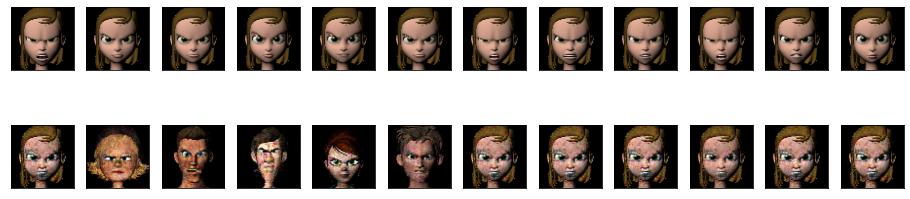

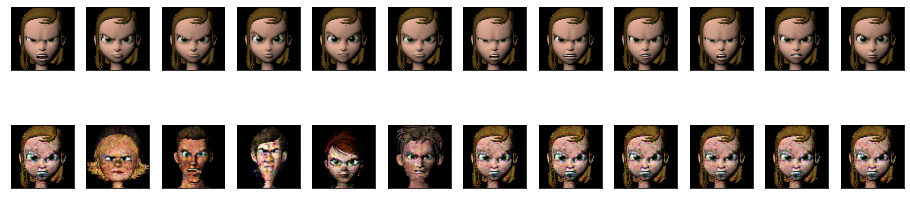

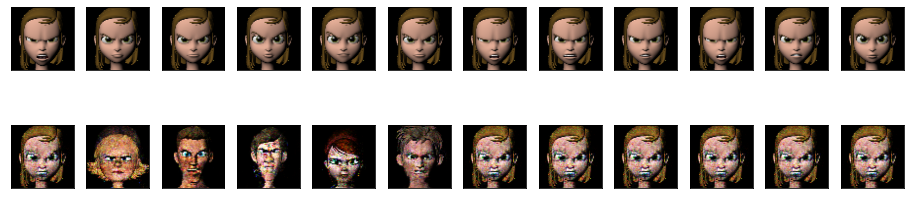

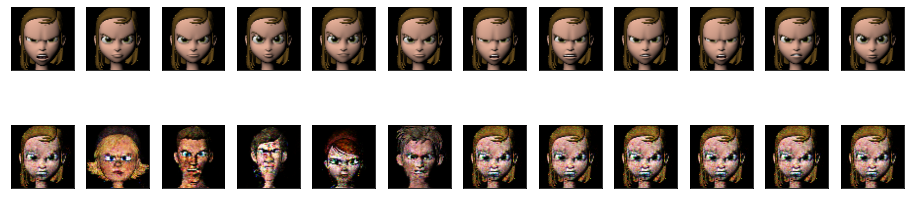

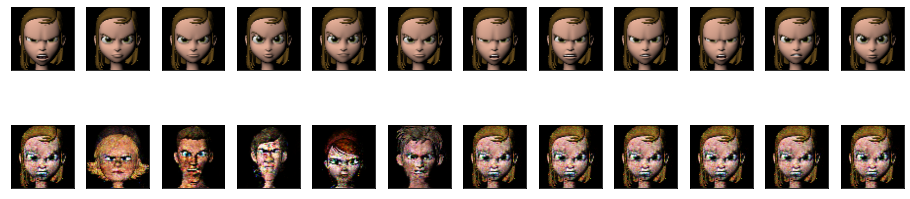

In [14]:
start_time = time.time()

train_for_n(nb_epoch=20, plt_frq=500, BATCH_SIZE=batch_size)
plotGeneratedImages(epoch=0, idx=75)

print(discriminator_acc())

process_time = time.time() - start_time
print("Elapsed: %s " % (process_time))

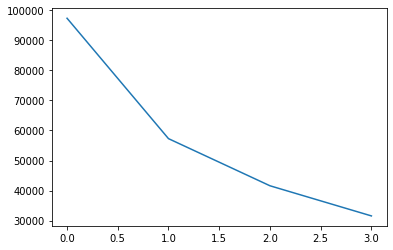

In [15]:
plt.plot(gan_losses)
plt.show()
#print(gan_losses)

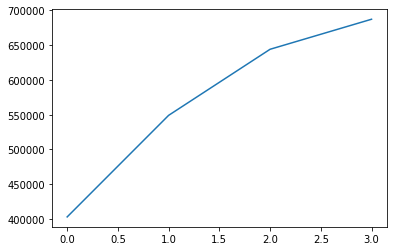

[403060.28, 549007.06, 643951.4, 687109.1]


In [16]:
new_dis_losses = []
for i in dis_losses:
    new_dis_losses.append(np.sum(i))
plt.plot(new_dis_losses)
plt.show()
print(new_dis_losses)